In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.integrate as integrate
from scipy.integrate import odeint, solve_ivp



import matplotlib.pyplot as plt
from matplotlib import animation, rc
from mpl_toolkits import mplot3d
import random as random
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

[0 1 2 3 4 5 6]


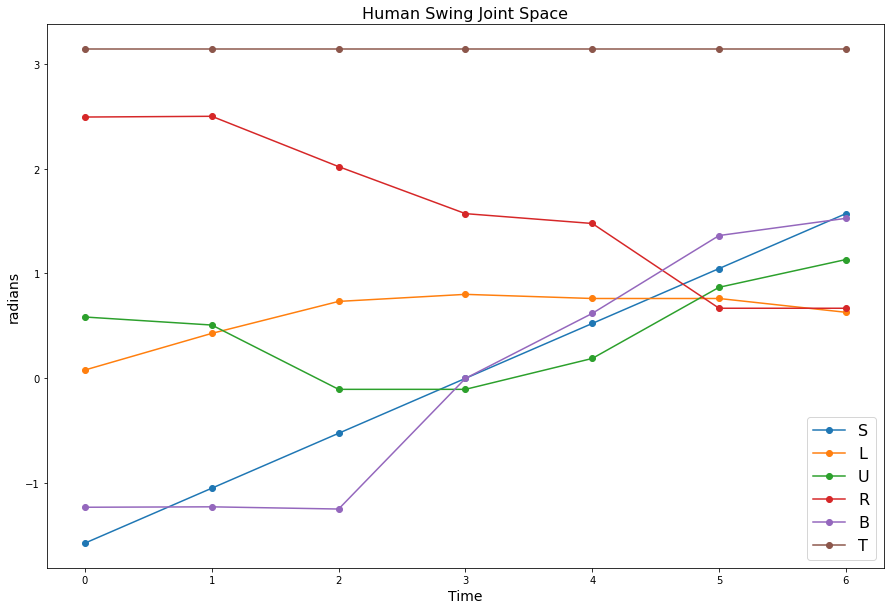

In [3]:
# The SUPER POINTS!!!

index = np.arange(0,7,1)
print(index)
S = [-np.pi/2,-np.pi/3,-np.pi/6,0,np.pi/6,np.pi/3,np.pi/2]
L = [.0799,.4289,.7338,.8011,.7616,.7616,.6299]
U = [.5850,.5085,-.1047,-.1047,.1899,.8684,1.133]
R = [2.492,2.499,2.019,np.pi/2,1.477,.6686,.6686]
B = [-1.229,-1.225,-1.246,0,.6196,1.362,1.526]
T = [np.pi,np.pi,np.pi,np.pi,np.pi,np.pi,np.pi]

#Plot them all
# creating an empty canvas
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(1,1,1)
ax.plot(index,S,'-o',index,L,'-o',index,U,'-o',index,R,'-o',index,B,'-o',index,T,'-o')
plt.legend(['S','L','U','R','B','T'],fontsize = 16)
ax.set_title('Human Swing Joint Space',fontsize = 16)
ax.set_xlabel('Time',fontsize = 14)
ax.set_ylabel('radians',fontsize = 14)
plt.show()

[2.492      2.4924375  2.492875   2.4933125  2.49375    2.4941875
 2.494625   2.4950625  2.4955     2.4959375  2.496375   2.4968125
 2.49725    2.4976875  2.498125   2.4985625  2.499      2.469
 2.439      2.409      2.379      2.349      2.319      2.289
 2.259      2.229      2.199      2.169      2.139      2.109
 2.079      2.049      2.019      1.99098727 1.96297454 1.93496181
 1.90694908 1.87893635 1.85092362 1.82291089 1.79489816 1.76688543
 1.7388727  1.71085997 1.68284725 1.65483452 1.62682179 1.59880906
 1.57079633 1.56493406 1.55907179 1.55320952 1.54734725 1.54148497
 1.5356227  1.52976043 1.52389816 1.51803589 1.51217362 1.50631135
 1.50044908 1.49458681 1.48872454 1.48286227 1.477      1.426475
 1.37595    1.325425   1.2749     1.224375   1.17385    1.123325
 1.0728     1.022275   0.97175    0.921225   0.8707     0.820175
 0.76965    0.719125   0.6686     0.6686     0.6686     0.6686
 0.6686     0.6686     0.6686     0.6686     0.6686     0.6686
 0.6686     0.6686     0.6

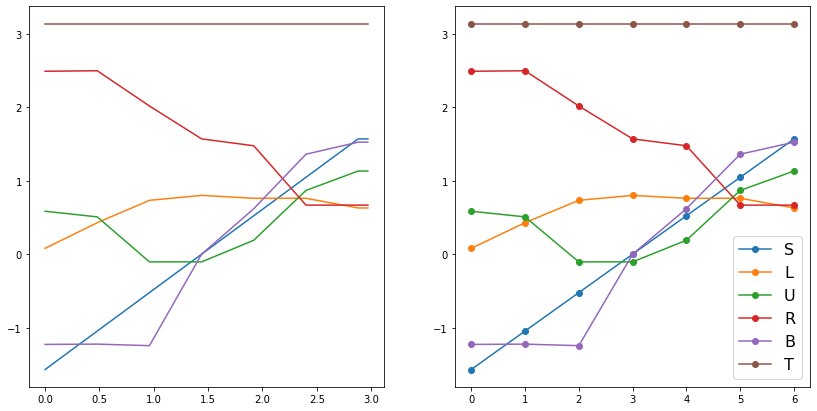

In [24]:

pts = 100


def Interp(theta,pts):
    add = np.floor(pts/(len(theta)-1))
    parts = np.zeros((6,int(add)))
    long_theta = []
                     
    for i in range(int(len(theta)-1)):
        delta = (theta[i+1]-theta[i])/add
        parts[i] = np.linspace(theta[i],theta[i+1]-delta,int(add))
    for j in range(int(len(parts))):
        long_theta = np.append(long_theta,parts[j])
    
    while len(long_theta)<pts:
        long_theta = np.append(long_theta,theta[-1])
    
    return long_theta

long_S = Interp(S,pts)
long_L = Interp(L,pts)
long_U = Interp(U,pts)
long_R = Interp(R,pts)
long_B = Interp(B,pts)
long_T = Interp(T,pts)
    
print(long_R)

t_start = 0
t_end =3
delta_t = t_end/pts
t_pts = np.arange(t_start,t_end,delta_t)

fig2 = plt.figure(figsize = (14,7))
ax2 = fig2.add_subplot(1,2,1)
ax3 = fig2.add_subplot(1,2,2)
ax2.plot(t_pts,long_S,'-')
ax2.plot(t_pts,long_L,'-')
ax2.plot(t_pts,long_U,'-')
ax2.plot(t_pts,long_R,'-')
ax2.plot(t_pts,long_B,'-')
ax2.plot(t_pts,long_T,'-')
ax3.plot(index,S,'-o')
ax3.plot(index,L,'-o')
ax3.plot(index,U,'-o')
ax3.plot(index,R,'-o')
ax3.plot(index,B,'-o')
ax3.plot(index,T,'-o')
plt.legend(['S','L','U','R','B','T'],fontsize = 16)
plt.show()

In [20]:
#Back to my robot vectors stuff. 

class Robot():
    
    #Class for the robot with lengths of links and the axis defined as they would be in the defalt zero position
    
    def __init__(self, links, axis = [[0,0,1],[0,1,0],[0,1,0],[0,1,0],[1,0,0]]):
        self.links = links
        self.axis = axis
        
    def rotateAxis(self, t, vec):
        
        #Rotation matrix just taken straight from wikepedia
        
        C = 1-np.cos(t);
        x,y,z = vec;

        Rot = [[x**2*C+np.cos(t), x*y*C-z*np.sin(t), z*x*C+y*np.sin(t)],
                [x*y*C+z*np.sin(t), y**2*C+np.cos(t), z*y*C-x*np.sin(t)],
                [x*z*C-y*np. sin(t), y*z*C+x*np.sin(t), z**2*C+np.cos(t)]]

        return Rot

    def findEnd(self, angles):
        #This function takes an input vector of angles and will output the end position as
        #well as all of the vectors of the robot NOT TRANSLATED FROM THE ORIGIN
        
        v1 = [0,0,0] #Base thing that moves with S
        v2 = [0,0,0] #First link that moves with L
        v3 = [0,0,0] #Second link that moves with U
        v4 = [0,0,0] #Shaft link that moves with B
        v5 = [0,0,0] #Club head that moves with T/R
        
        #Starting Vector
        v1_0 = [self.links[0]/np.sqrt(2),0,self.links[0]/np.sqrt(2)]
        v5_0 = [self.links[4]/np.sqrt(2),0,self.links[4]/np.sqrt(2)]
        
        #First rotation
        v1 = np.dot(v1_0,self.rotateAxis(angles[0], self.axis[0]))
        axis1 = np.dot(self.axis[1],self.rotateAxis(angles[0], self.axis[0]))
        axis2 = np.dot(self.axis[2],self.rotateAxis(angles[0], self.axis[0]))
        axis3 = np.dot(self.axis[3],self.rotateAxis(angles[0], self.axis[0]))
        axis4 = np.dot(self.axis[4],self.rotateAxis(angles[0], self.axis[0]))
        
        #Second Rotation
        v2 = (self.links[1]/self.links[0])*np.dot(v1,self.rotateAxis(angles[1], axis1))
        axis2 = np.dot(axis2,self.rotateAxis(angles[1], axis1))
        axis3 = np.dot(axis3,self.rotateAxis(angles[1], axis1))
        axis4 = np.dot(axis4,self.rotateAxis(angles[1], axis1))
        
        #Third Rotation
        v3 = (self.links[2]/self.links[1])*np.dot(v2,self.rotateAxis(angles[2], axis2))
        axis3 = np.dot(axis3,self.rotateAxis(angles[2], axis2))
        axis4 = np.dot(axis4,self.rotateAxis(angles[2], axis2))

        #Fourth rotation
        axis3 = np.dot(axis3,self.rotateAxis(angles[3], v3/self.links[2])) #This needs to be a unit vector!!!!
        axis4 = np.dot(axis4,self.rotateAxis(angles[3], v3/self.links[2]))
        
        #Fifth Rotation
        v4 = (self.links[3]/self.links[2])*np.dot(v3,self.rotateAxis(angles[4], axis3))
        axis4 = np.dot(axis4,self.rotateAxis(angles[4], axis3))
        
        #Sixth Rotation
        v5 = np.dot(v5_0,self.rotateAxis(angles[5], axis4))
        
        
        x_val = v1[0]+v2[0]+v3[0]+v4[0]+v5[0]
        y_val = v1[1]+v2[1]+v3[1]+v4[1]+v5[1]
        z_val = v1[2]+v2[2]+v3[2]+v4[2]+v5[2]
        
        return [x_val, y_val, z_val, v1, v2, v3, v4, v5]
    
    def distanceFromTarget(self,targ,angles):
        
        #Simply finds the distance between a given end from a set of angles and a target end point
        
        end = self.findEnd(angles)
        dist = (end[0]-targ[0])**2+(end[1]-targ[1])**2+(end[2]-targ[2])**2
        
        return dist
    



In [21]:
def drawRobot(v1,v2,v3,v4,v5):
    
    #I guess the name of this function is deceptive but it takes the vectors and translates them essentially
    
    x = np.zeros(100,)
    y = np.zeros(100,)
    z = np.zeros(100,)

    # This is an admittedly weird way to do this, but it is what it is.
    # The process is like walking along in the direction of vectors 1-5 until you reach the end
    # The magnitude of the links are arbitrary but the relative size is still normal as defined
    
    for i in range(100):
        if i <= 19:
            x[i] = i*v1[0]
            y[i] = i*v1[1]
            z[i] = i*v1[2]
        elif i > 19 and i<=39:
            x[i] = 19*v1[0] + (i-19)*v2[0]
            y[i] = 19*v1[1] + (i-19)*v2[1]
            z[i] = 19*v1[2] + (i-19)*v2[2]
        elif i > 39 and i<=59:
            x[i] = 19*v1[0] + 20*v2[0]+ (i-39)*v3[0]
            y[i] = 19*v1[1] + 20*v2[1]+ (i-39)*v3[1]
            z[i] = 19*v1[2] + 20*v2[2]+ (i-39)*v3[2]
        elif i > 59 and i<=79:
            x[i] = 19*v1[0] + 20*v2[0] + 20*v3[0] + (i-59)*v4[0]
            y[i] = 19*v1[1] + 20*v2[1] + 20*v3[1] + (i-59)*v4[1]
            z[i] = 19*v1[2] + 20*v2[2] + 20*v3[2] + (i-59)*v4[2]
        else:
            x[i] = 19*v1[0] + 20*v2[0] + 20*v3[0] + 20*v4[0] + (i-79)*v5[0]
            y[i] = 19*v1[1] + 20*v2[1] + 20*v3[1] + 20*v4[1] + (i-79)*v5[1]
            z[i] = 19*v1[2] + 20*v2[2] + 20*v3[2] + 20*v4[2] + (i-79)*v5[2]
    
    return x,y,z

In [22]:
def drawRobot2(v1,v2,v3,v4,v5):
    
    x = np.zeros(6,)
    y = np.zeros(6,)
    z = np.zeros(6,)
    
    x[0],y[0],z[0] = [0,0,0]
    x[1],y[1],z[1] = v1
    x[2],y[2],z[2] = v1+v2
    x[3],y[3],z[3] = v1+v2+v3
    x[4],y[4],z[4] = v1+v2+v3+v4
    x[5],y[5],z[5] = v1+v2+v3+v4+v5
    
    print(x)
    print(y)
    print(z)
    
    return x,y,z

[48.329734006630005, -24.395183950935884, -15.82749891406172]
[ 0.          3.86363145 18.92265051 31.86231991 46.91552044 48.32973401]
[  0.           0.           0.           0.         -24.39518395
 -24.39518395]
[  0.           3.86363145  18.45701506   1.95532254 -17.24171248
 -15.82749891]


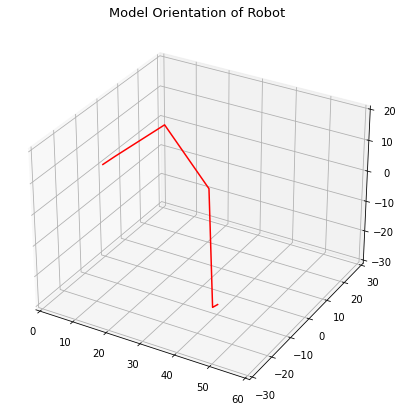

In [23]:
# Make a real robot 

real_links = np.array([5.464,20.97,20.97,34.5,2])
links = real_links*(1/20)
#print(links)
axis = [[0,0,1],[0,1,0],[0,1,0],[0,1,0],[1,0,0]]

S = [-np.pi/2,-np.pi/3,-np.pi/6,0,np.pi/6,np.pi/3,np.pi/2]
L = [.0799,.4289,.7338,.8011,.7616,.7616,.6299]
U = [.5850,.5085,-.1047,-.1047,.1899,.8684,1.133]
R = [2.492,2.499,2.019,np.pi/2,1.477,.6686,.6686]
B = [-1.229,-1.225,-1.246,0,.6196,1.362,1.526]
T = [np.pi,np.pi,np.pi,np.pi,np.pi,np.pi,np.pi]

#anglesDesired = [np.pi/4,0,0,np.pi/2,np.pi/2,0]
anglesDesired = [S[3],L[3],U[3],R[3],B[3]-np.pi/4,T[3]]
#anglesDesired = [0,.5,.5,10,1,10]

#Changing from normal physics conventions of angle definition to the way the robot defines them:
anglesConvention = [-1*anglesDesired[0],(np.pi/4-anglesDesired[1]),\
                    (-np.pi/2+anglesDesired[2]),anglesDesired[3],anglesDesired[4],np.pi-anglesDesired[5]]

Moto = Robot(links = real_links, axis = axis)
End = Moto.findEnd(anglesConvention)
print([End[0],End[1],End[2]])

#Show on a 3D plot

v1,v2,v3,v4,v5 = End[3],End[4],End[5],End[6],End[7]

x,y,z = drawRobot2(v1,v2,v3,v4,v5)
             
#print(x)
#print(y)
#print(z) 


# creating an empty canvas
fig = plt.figure(figsize = (7,7))

# defining the axes with the projection
# as 3D so as to plot 3D graphs
ax = plt.axes(projection="3d")
ax.set_xlim(0,60)
ax.set_ylim(-30,30)
ax.set_zlim(-30,20)

# plotting a 3D line graph with X-coordinate,
# Y-coordinate and Z-coordinate respectively
ax.plot3D(x,y,z, 'red')


 
# Showing the above plot
plt.title('Model Orientation of Robot',fontsize=13)
plt.show()

In [27]:
# Look at the end of the robot as it goes through this swing, then try to say something about the velcoity of the club head

x_end = np.zeros(pts,)
y_end = np.zeros(pts,)
z_end = np.zeros(pts,)
dist = np.zeros(pts-1,)

for i in range(pts):
    
    anglesDesired = [long_S[i],long_L[i],long_U[i],long_R[i],long_B[i],long_T[i]]
    #Changing from normal physics conventions of angle definition to the way the robot defines them:
    anglesConvention = [-1*anglesDesired[0],(np.pi/4-anglesDesired[1]),\
                        (-np.pi/2+anglesDesired[2]),anglesDesired[3],anglesDesired[4],np.pi-anglesDesired[5]]
    
    End = Moto.findEnd(anglesConvention)
    x_end[i],y_end[i],z_end[i] = End[0],End[1],End[2]
    
    dist[i] = np.sqrt((x_end[i+1]-x_end[i])**2+(y_end[i+1]-y_end[i])**2+(z_end[i+1]-z_end[i])**2)
    
    
print(x_end)



[-18.24641454 -17.47164393 -16.58101493 -15.57698105 -14.46233527
 -13.24020113 -11.91402268 -10.4875534   -8.96484416  -7.35023022
  -5.64831727  -3.86396663  -2.00227972  -0.06858159   1.93159608
   3.99253276   6.10833736   7.99412698   9.92277187  11.87176883
  13.8185534   15.74076761  17.6165264   19.42467898  21.14506206
  22.75874136  24.2482385   25.59774006  26.79328623  27.82293631
  28.67690909  29.34769592  29.83014515  32.36857872  34.87458826
  37.32311351  39.68950961  41.94987648  44.08137521  46.06252724
  47.87349175  49.49631772  50.91516717  52.11650666  53.08926465
  53.82495298  54.31775115  54.56455274  54.56497383  55.34990671
  55.94998895  56.36015117  56.57624702  56.59509788  56.41453163
  56.03341531  55.45168109  54.67034524  53.69152005  52.51841809
  51.15534907  49.60770877  47.88196036  45.9856078   43.92716167
  42.41477057  40.66207895  38.68202181  36.49214724  34.11447244
  31.57522325  28.9044591   26.13558831  23.30478187  20.45029725
  17.61172

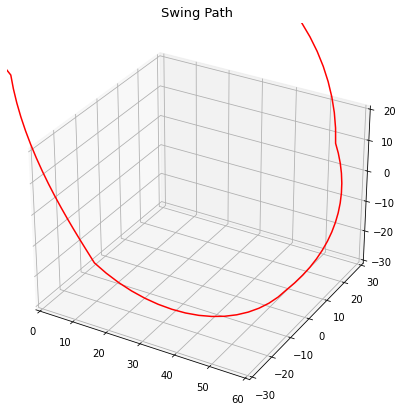

In [28]:
# creating an empty canvas
fig2 = plt.figure(figsize = (7,7))

# defining the axes with the projection
# as 3D so as to plot 3D graphs
ax2 = plt.axes(projection="3d")
ax2.set_xlim(0,60)
ax2.set_ylim(-30,30)
ax2.set_zlim(-30,20)

# plotting a 3D line graph with X-coordinate,
# Y-coordinate and Z-coordinate respectively
ax2.plot3D(x_end,y_end,z_end, 'red')


 
# Showing the above plot
plt.title('Swing Path',fontsize=13)
plt.show()

In [45]:
def makeTime(x_end,y_end,z_end,max_vel):
    #Initalize Everything
    pts = 100
    time = 0
    t_array = np.array([0])
    vel = np.zeros(pts,)
    dist = np.zeros(pts-1,)
    
    #Make the velocity of the actual club a gauss curve
    for i in range(len(t_pts-1)):
        vel[i] = max_vel*np.exp(-(i-50)**2/(2*35**2))
        
    for i in range(pts-1):
        dist[i] = np.sqrt((x_end[i+1]-x_end[i])**2+(y_end[i+1]-y_end[i])**2+(z_end[i+1]-z_end[i])**2)
        time = time + dist[i]/vel[i];
        t_array = np.append(t_array,time)
        
    return t_array,vel,dist
   
    


[0.         0.05299764 0.104162   0.15360664 0.20143686 0.24775031
 0.29263768 0.33618324 0.37846533 0.41955693 0.459526   0.49843595
 0.53634597 0.57331138 0.60938395 0.64461215 0.67904146 0.72815237
 0.77583752 0.82211269 0.86699051 0.91048099 0.95259208 0.99333017
 1.03270054 1.07070784 1.10735644 1.14265087 1.17659617 1.20919825
 1.24046431 1.27040312 1.2990255  1.33681866 1.37467789 1.41259091
 1.45054394 1.48852197 1.52650908 1.56448861 1.6024434  1.64035587
 1.67820822 1.71598245 1.75366044 1.79122407 1.82865518 1.86593562
 1.90304733 1.93055057 1.95819403 1.98599181 2.01395807 2.04210697
 2.07045275 2.09900965 2.12779196 2.15681398 2.18609006 2.21563455
 2.24546184 2.27558637 2.3060226  2.33678504 2.36788824 2.40921369
 2.45142836 2.4944967  2.53838187 2.58304561 2.62844812 2.67454811
 2.7213029  2.76866858 2.81660043 2.86505329 2.91398225 2.96334332
 3.01309434 3.06319596 3.11361278 3.14366464 3.17420362 3.20525762
 3.2368561  3.26903015 3.30181264 3.33523836 3.36934411 3.4041

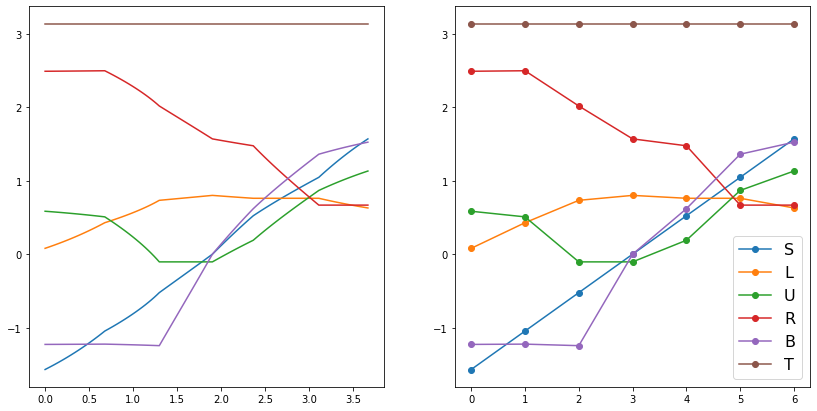

In [52]:
max_vel = 10*12 #in/sec
t_array,vel,dist = makeTime(x_end,y_end,z_end,max_vel)

print(t_array)
print(np.size(t_array))
print(vel)
print(dist)

fig4 = plt.figure(figsize = (14,7))
ax4 = fig4.add_subplot(1,2,1)
ax5 = fig4.add_subplot(1,2,2)
ax4.plot(t_array,long_S,'-')
ax4.plot(t_array,long_L,'-')
ax4.plot(t_array,long_U,'-')
ax4.plot(t_array,long_R,'-')
ax4.plot(t_array,long_B,'-')
ax4.plot(t_array,long_T,'-')
ax5.plot(index,S,'-o')
ax5.plot(index,L,'-o')
ax5.plot(index,U,'-o')
ax5.plot(index,R,'-o')
ax5.plot(index,B,'-o')
ax5.plot(index,T,'-o')
plt.legend(['S','L','U','R','B','T'],fontsize = 16)
plt.show()